# Analyzing Fair PCA on different datasets


### Imports


In [257]:
from sklearn.model_selection import train_test_split
import dython
import numpy as np
import scipy
import scipy.optimize as opt
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
import fairlearn.metrics as flm

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import sklearn.tree as tree
import seaborn as sns
import pandas as pd

import xgboost
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import shap

## Functions
We put all out functions in this section for a better overview.

In [258]:
def calculate_metrics(y_true, y_pred):
    """
    Parameters
    ----------
    y_true : array-like of shape (n_samples,)
        Ground truth (correct) target values.
    y_pred : array-like of shape (n_samples,)
        Estimated targets as returned by a classifier.

    Returns
    -------
    recall : float
        Recall of the positive class in binary classification or weighted
        average of the recall of each class for the multiclass task.
    precision : float
        Precision of the positive class in binary classification or weighted
        average of the precision of each class for the multiclass task.
    f1_score : float
        F1 score of the positive class in binary classification or weighted
        average of the F1 score of each class for the multiclass task.
    accuracy : float
        Accuracy of the positive class in binary classification or weighted
        average of the accuracy of each class for the multiclass task.
    """

    TP = np.sum(np.logical_and(y_pred == 1, y_true == 1))
    FP = np.sum(np.logical_and(y_pred == 1, y_true == 0))
    TN = np.sum(np.logical_and(y_pred == 0, y_true == 0))
    FN = np.sum(np.logical_and(y_pred == 0, y_true == 1))

    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    f1_score = 2 * (precision * recall) / (precision + recall)
    accuracy = (TP/(TP+FN) + TN/(TN+FP)) / 2

    metrics_dict = {'recall': recall,
                    'precision': precision,
                    'f1_score': f1_score,
                    'accuracy': accuracy}
    
    return metrics_dict


In [259]:
def calc_fair_metrics_flm(y_test, y_pred, groups):

    results = {}

    for group in groups:
        results[group] = {}
        results[group]["equalized_odds"] = round(flm.equalized_odds_ratio(y_test, y_pred, sensitive_features=groups[group]), 3)
        results[group]["demographic_parity"] = round(flm.demographic_parity_ratio(y_test, y_pred, sensitive_features=groups[group]), 3)

    return results

In [260]:
def calc_ratios_flm(y_test, y_pred, groups):
    grp_idxs = {}
    for group in groups:
        grp_idxs[group] = {}
        grp_idxs[group][0] = np.where(groups[group] == 0)
        grp_idxs[group][1] = np.where(groups[group] == 1)
    
    results = {}
    for group in groups:
        results[group] = {}
        for i in [0, 1]:
            results[group][i] = {}
            group_idx = grp_idxs[group][i]
            y_true_group = y_test[group_idx]
            y_pred_group = y_pred[group_idx]
            results[group][i]["tpr"] = round(flm.true_positive_rate(y_true_group, y_pred_group), 3)
            results[group][i]["fpr"] = round(flm.false_positive_rate(y_true_group, y_pred_group), 3)
            results[group][i]["tnr"] = round(flm.true_negative_rate(y_true_group, y_pred_group), 3)
            results[group][i]["fnr"] = round(flm.false_negative_rate(y_true_group, y_pred_group), 3)
    
    return results

In [261]:
# calculate uncertainty by bootstrapping
def calc_certainty(y_test, y_pred):
    n_bootstraps = 1000
    bootstrapped_scores = []
    interval = 0.95
    for i in range(n_bootstraps):
        # bootstrap by sampling with replacement on the prediction indices
        indices = np.random.randint(low=0, high=len(y_pred), size=len(y_pred))
        if len(np.unique(y_test[indices])) < 2:
            # We need at least one positive and one negative sample for ROC AUC
            continue

        score = calculate_metrics(y_test[indices], y_pred[indices])['f1_score']
        bootstrapped_scores.append(score)

    print(f"Confidence interval for the f1_score [{interval}]:" + "[{:0.3f} - {:0.3}]".format(
        np.percentile(bootstrapped_scores, ((1-interval)/2)*100),
        np.percentile(bootstrapped_scores, (interval + (1-interval)/2)*100)))

In [262]:
# apply unfair PCA
def unfair_pca(pca, non_protected_features_scaled):

    X_pca = pca.fit_transform(non_protected_features_scaled)

    # pca.explained_variance_ratio_
    # scree plot bar plot
    plt.bar(range(1,len(pca.explained_variance_ratio_)+1), pca.explained_variance_ratio_*100)
    for i in range(len(pca.explained_variance_ratio_)):
        plt.text(i+0.7, pca.explained_variance_ratio_[i]*100+0.3, str(round(pca.explained_variance_ratio_[i]*100,2))+'%')
    plt.xlabel('Principal Component')
    plt.show()

    return X_pca

In [263]:
def plot_pca_corr(X_pca, protected, groups, figsize=(24, 3)):

    df = pd.DataFrame(np.concatenate((protected, X_pca), axis=1))
    corr = df.corr()
    
    pc_list = ["PC" + str(i) for i in range(1, X_pca.shape[1]+1)]
    corr.columns = groups + pc_list

    rows_to_plot = [x for x in corr.columns if "PC" in x]
    indices_to_plot = range(len(groups))
    corr = corr.loc[indices_to_plot, rows_to_plot]
    indices = groups
    corr.index = indices
    plt.figure(figsize=figsize)
    sns.heatmap(corr,
                cmap='RdBu_r',
                annot=True,
                linewidth=0.5,
                vmin=-0.2,
                vmax=0.2,
                fmt='.2f');
    plt.show()

In [264]:
def reconstruction_error(X_pca_test, pca, non_protected_features_scaled_test, protected):
    # project test data with pca
    X_pca_test = pca.transform(non_protected_features_scaled_test)

    # project it back into the original space
    X_reconstructed_test = pca.inverse_transform(X_pca_test)

    # calculate reconstruction error for each sample as mean absolute error
    reconstruction_error_test = []
    for i in range(len(non_protected_features_scaled_test)):
        reconstruction_error_test.append(np.mean(np.abs(non_protected_features_scaled_test[i] - X_reconstructed_test[i])))

    # get reconstruction error for protected features
    female_error = []
    male_error = []
    whites_error = []
    african_american_error = []
    for i in range(len(reconstruction_error_test)):

        # 1 is white and 0 is african american
        if protected[i][0] == 1:
            whites_error.append(reconstruction_error_test[i])
        else:
            african_american_error.append(reconstruction_error_test[i])
            
        # 1 is male and 0 is female
        if protected[i][1] == 1:
            male_error.append(reconstruction_error_test[i])
        else:
            female_error.append(reconstruction_error_test[i])

    # calculate mean reconstruction error for each group
    print(np.mean(male_error))
    print(np.mean(female_error))
    print(np.mean(whites_error))
    print(np.mean(african_american_error))


In [265]:
# apply fair PCA
def fair_pca(non_protected_features_scaled, protected, n_components):
    X = non_protected_features_scaled.copy()
    # create Matrix Z with protected features
    Z = protected.copy()
    # remove mean from each column
    Z = Z - np.mean(Z, axis=0)
    # find orthonormal null space spanned by ZTX with scipy.linalg.null_space
    R = scipy.linalg.null_space(Z.T @ X)

    # Find orthonormal eigenvectors RTXTXR with scipy.linalg.eig
    eigvals, eigvecs = scipy.linalg.eig((R.T @ X.T) @ (X @ R))
    # sort eigenvectors by eigenvalues
    idx = eigvals.argsort()[::-1]
    eigvals = eigvals[idx]
    eigvecs = eigvecs[:,idx]

    # get matrix of first n eigenvectors
    L = eigvecs[:,:n_components]

    # projection matrix U = RL
    U = R @ L

    # project data
    X_projected = X @ U

    return X_projected, Z, U


In [266]:
def reconstruction_error_fair_pca(X_projected, X_test_projected, U, non_protected_features_scaled_test, protected):

    # reproject it back into the original space
    X_reconstructed = X_projected @ U.T
    X_reconstructed_test = X_test_projected @ U.T

    # calculate reconstruction error for each sample as mean absolute error
    reconstruction_error = []
    for i in range(len(non_protected_features_scaled)):
        reconstruction_error.append(np.mean(np.abs(non_protected_features_scaled[i] - X_reconstructed[i])))
    reconstruction_error_test = []
    for i in range(len(non_protected_features_scaled_test)):
        reconstruction_error_test.append(np.mean(np.abs(non_protected_features_scaled_test[i] - X_reconstructed_test[i])))
    # get reconstruction error for protected features
    female_error = []
    male_error = []
    whites_error = []
    african_american_error = []
    for i in range(len(reconstruction_error_test)):

        # 1 is white and 0 is african american
        if protected[i][0] == 1:
            whites_error.append(reconstruction_error_test[i])
        else:
            african_american_error.append(reconstruction_error_test[i])
            
        # 1 is male and 0 is female
        if protected[i][1] == 1:
            male_error.append(reconstruction_error_test[i])
        else:
            female_error.append(reconstruction_error_test[i])

    # calculate mean reconstruction error for each group
    print(np.mean(male_error))
    print(np.mean(female_error))
    print(np.mean(whites_error))
    print(np.mean(african_american_error))

## Recidivism


In [267]:
df_recidivism = pd.read_csv(f'data/propublica_data_for_fairml.csv')

df_recidivism['Caucasian'] = ((df_recidivism['Other'] == 0) & (df_recidivism['African_American'] == 0) & (
    df_recidivism['Asian'] == 0) & (df_recidivism['Hispanic'] == 0) & (df_recidivism['Native_American'] == 0)).astype(int)
df_recidivism['Between_TwentyFive_And_FourtyFive'] = (
    (df_recidivism['Age_Above_FourtyFive'] == 0) & (df_recidivism['Age_Below_TwentyFive'] == 0)).astype(int)
df_recidivism['Male'] = (df_recidivism['Female'] == 0).astype(int)

# revert one hot encoding
races = ['Other', 'African_American', 'Asian', 'Hispanic', 'Native_American', 'Caucasian']
df_recidivism['Race'] = df_recidivism[races].idxmax(axis=1)
df_recidivism = df_recidivism.drop(races, axis=1)

genders = ['Female', 'Male']
df_recidivism['Gender'] = df_recidivism[genders].idxmax(axis=1)
df_recidivism = df_recidivism.drop(genders, axis=1)

age_group = ['Age_Above_FourtyFive', 'Age_Below_TwentyFive', 'Between_TwentyFive_And_FourtyFive']
df_recidivism['Age_Group'] = df_recidivism[age_group].idxmax(axis=1)
df_recidivism = df_recidivism.drop(age_group, axis=1)

df_recidivism = df_recidivism.drop('score_factor', axis=1)
df_recidivism = df_recidivism[df_recidivism["Race"].isin(["African_American", "Caucasian"])]
df_recidivism = df_recidivism.reset_index(drop=True)


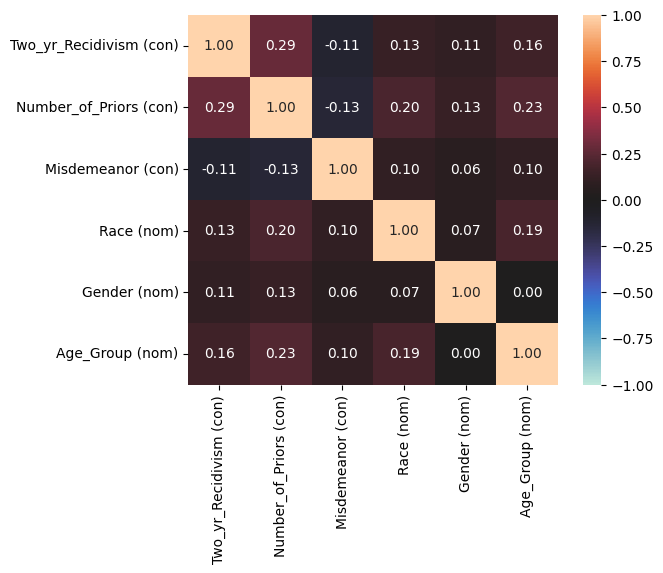

In [268]:
cat_cols = ["Race", "Gender", "Age_Group"]
dython.nominal.associations(df_recidivism, nominal_columns=cat_cols, mark_columns=True);

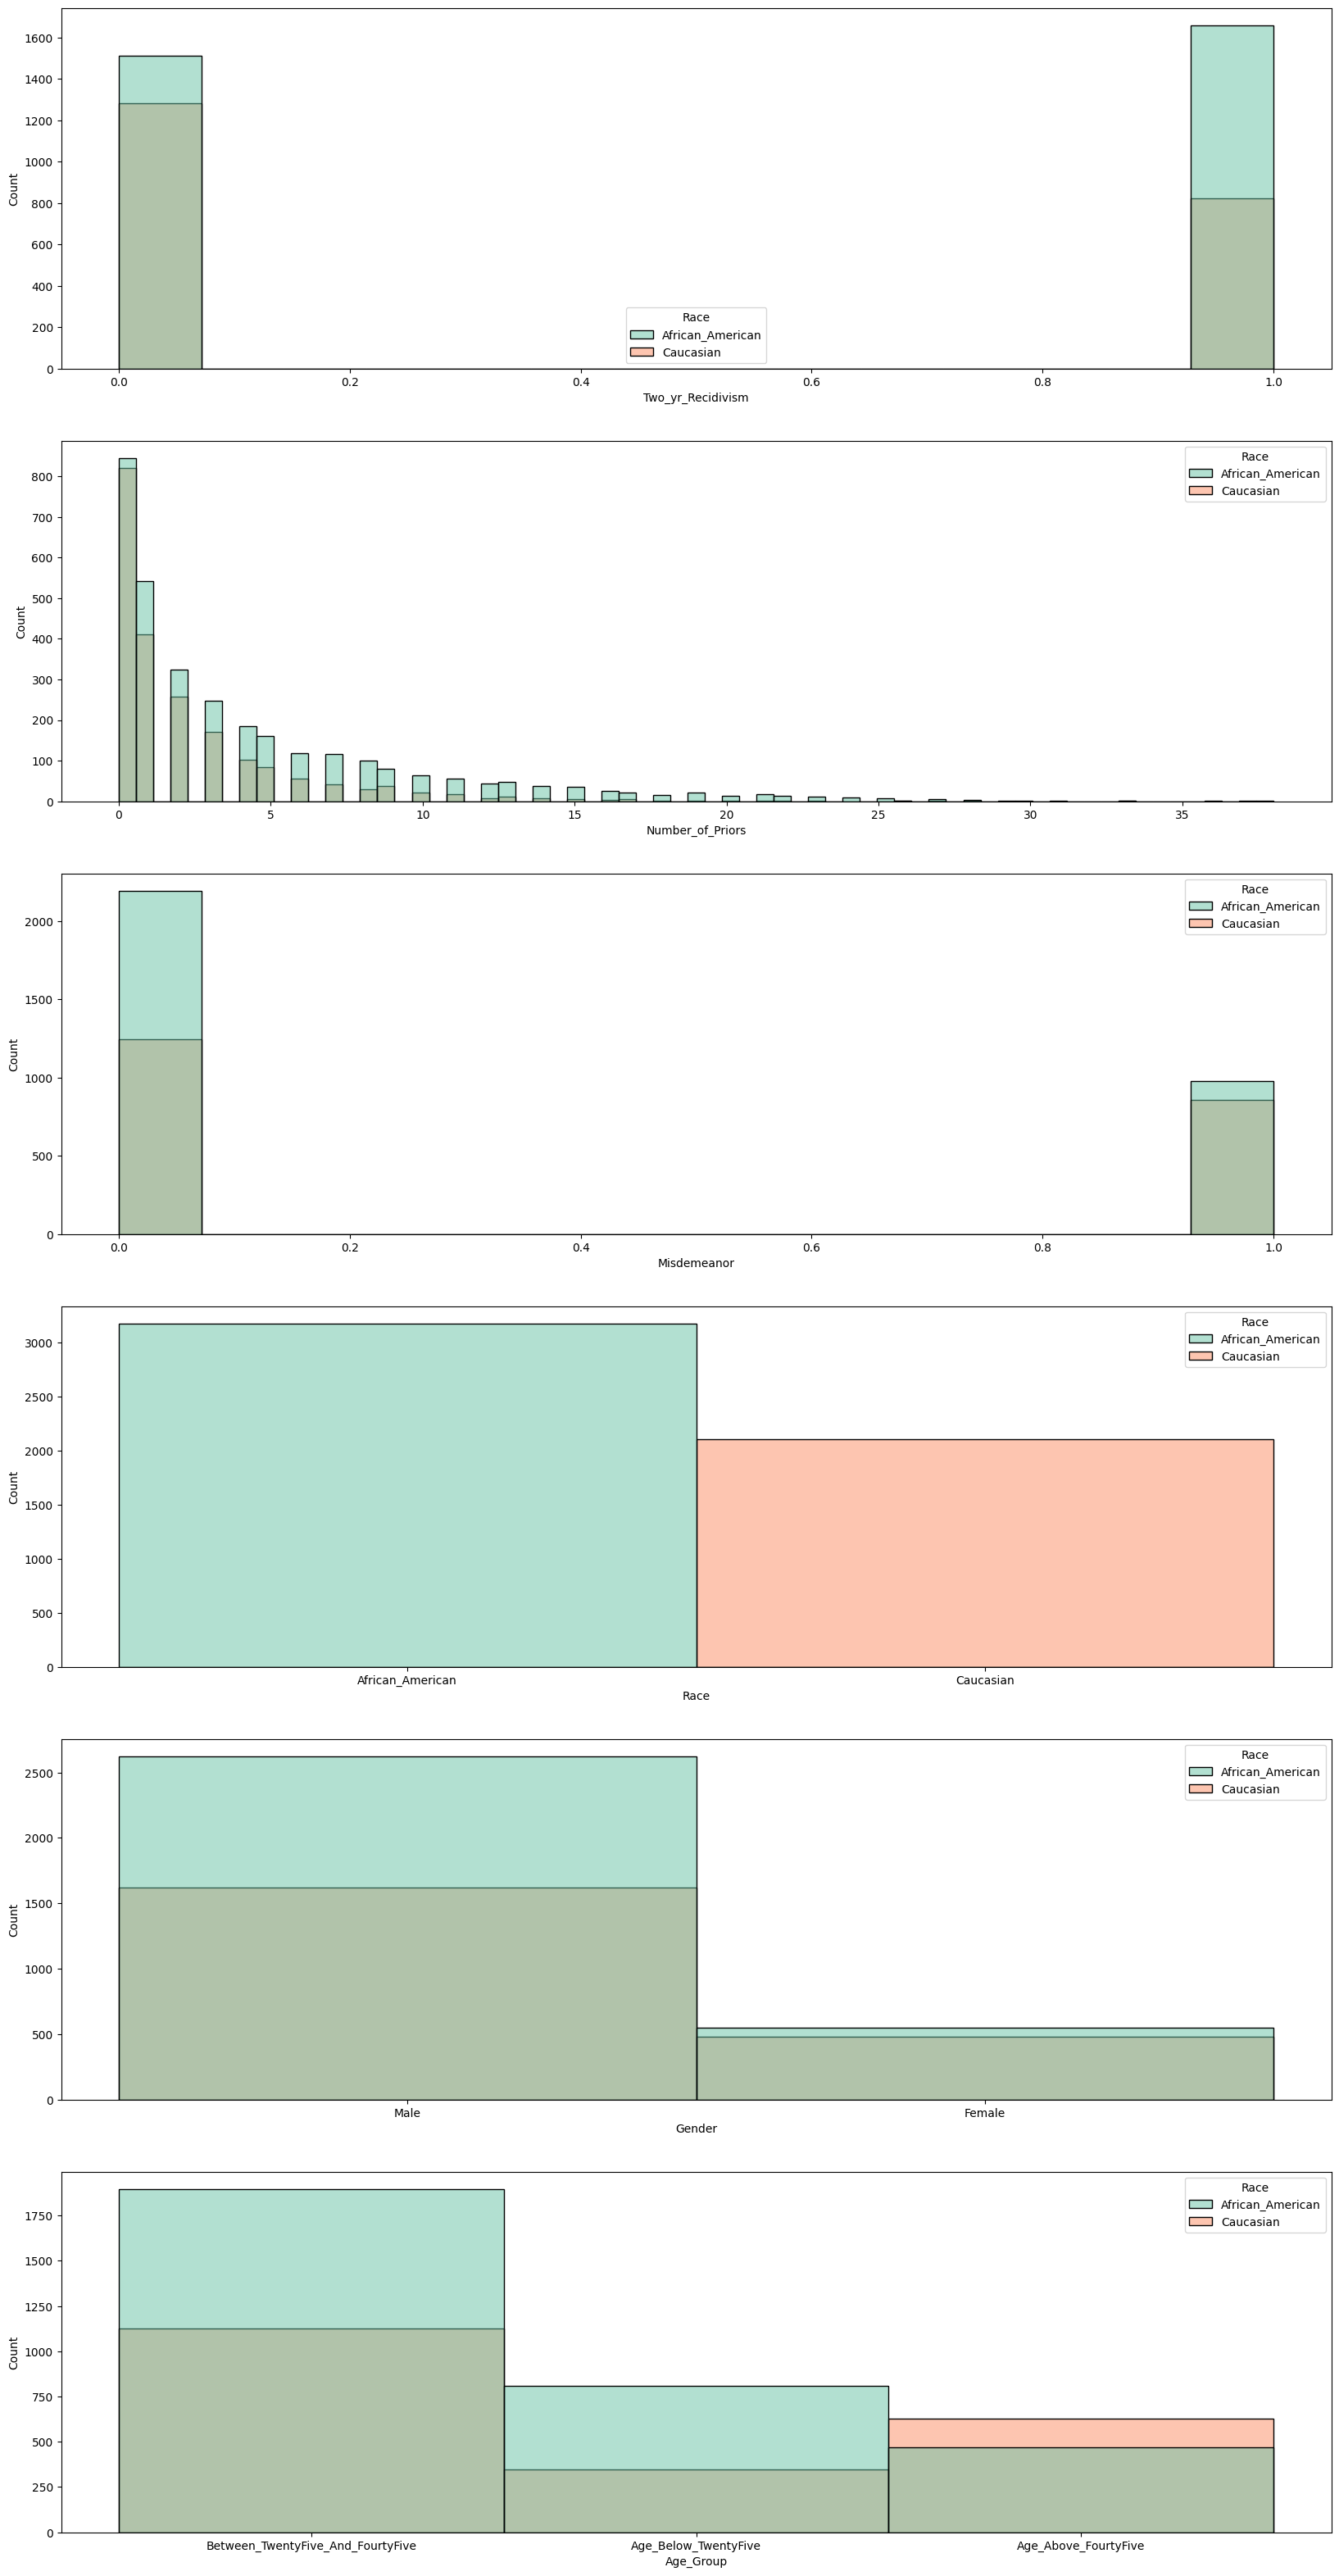

In [269]:
# plot feature distributions for both genders in one plot
fig, axes = plt.subplots(len(df_recidivism.columns), figsize=(20, 40))
for i, feature in enumerate(df_recidivism.columns):
    sns.histplot(data=df_recidivism, x=feature, hue='Race', ax=axes[i], palette='Set2')
# plt.show()


In [270]:
# one hot encode data
dummies_df_recividism = pd.get_dummies(df_recidivism, columns=cat_cols, drop_first=True)
# remove target variable from features
labels = dummies_df_recividism.Two_yr_Recidivism
features = dummies_df_recividism.drop("Two_yr_Recidivism", axis=1)

features = features[["Number_of_Priors", "Misdemeanor", "Age_Group_Age_Below_TwentyFive",
                     "Age_Group_Between_TwentyFive_And_FourtyFive", "Race_Caucasian", "Gender_Male"]]

# identify protected groups
indices = []
for i, f in enumerate(features.columns):
    if ("Race" in f) or ("Gender" in f):
        print("Column ID: %s" % i, "(%s)" % f)
        indices.append(i)

print(indices)

groups = features.iloc[:, indices]

X_train, X_test, y_train, y_test, group_train, group_test = train_test_split(
    features.values, labels.values.reshape(-1), groups, test_size=0.3, random_state=0, shuffle=True)


Column ID: 4 (Race_Caucasian)
Column ID: 5 (Gender_Male)
[4, 5]


In [271]:
# last columns of our data contains the protected features
protected = X_train[:, -2:]
nonprotected = X_train[:, :-2]

protected_test = X_test[:, -2:]
nonprotected_test = X_test[:, :-2]


### with XGBoost


In [272]:
xgb = xgboost.XGBClassifier(n_estimators=100, max_depth=4, learning_rate=0.1, random_state=0)
scaler = ColumnTransformer([('scaler', MinMaxScaler(), slice(0, 1))], remainder='passthrough') # scale only the first column (Number_of_Priors), leave the remainder untouched
xgb_pipeline = Pipeline([('scaler', scaler), ('xgb', xgb)])
xgb_pipeline.fit(nonprotected, y_train)
y_pred_xgb = xgb_pipeline.predict(nonprotected_test)
metric_scores = calculate_metrics(y_test, y_pred_xgb)
print("Balanced accuracy on test set:", metric_scores['accuracy'])
print("Precision on test set:", metric_scores['precision'])
print("Recall on test set:", metric_scores['recall'])
print("F1 score on test set:", metric_scores['f1_score'])

Balanced accuracy on test set: 0.6621302003329241
Precision on test set: 0.6409883720930233
Recall on test set: 0.610803324099723
F1 score on test set: 0.625531914893617


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


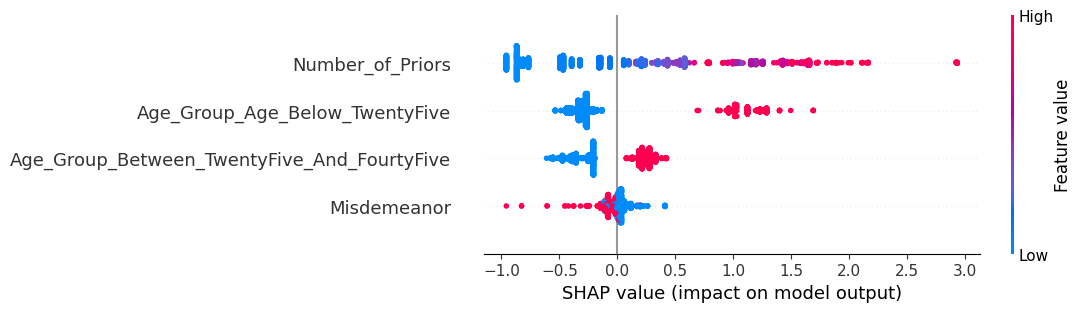

In [273]:
X_train_ = xgb_pipeline['scaler'].transform(nonprotected)
X_test_ = xgb_pipeline['scaler'].transform(nonprotected_test)

# explain the model's predictions using SHAP
explainer = shap.Explainer(xgb_pipeline['xgb'], X_train_, feature_names=features.columns[:-2])
shap_values = explainer(X_test_)
shap.plots.beeswarm(shap_values, max_display=10)

In [274]:
results = calc_fair_metrics_flm(y_test, y_pred_xgb, group_test)
ratio_results = calc_ratios_flm(y_test, y_pred_xgb, group_test)
print(results)
print(ratio_results)

{'Race_Caucasian': {'equalized_odds': 0.591, 'demographic_parity': 0.545}, 'Gender_Male': {'equalized_odds': 0.579, 'demographic_parity': 0.608}}
{'Race_Caucasian': {0: {'tpr': 0.705, 'fpr': 0.351, 'tnr': 0.649, 'fnr': 0.295}, 1: {'tpr': 0.42, 'fpr': 0.207, 'tnr': 0.793, 'fnr': 0.58}}, 'Gender_Male': {0: {'tpr': 0.455, 'fpr': 0.184, 'tnr': 0.816, 'fnr': 0.545}, 1: {'tpr': 0.643, 'fpr': 0.318, 'tnr': 0.682, 'fnr': 0.357}}}


In [275]:
calc_certainty(y_test, y_pred_xgb)

Confidence interval for the f1_score [0.95]:[0.594 - 0.654]


### Fair PCA


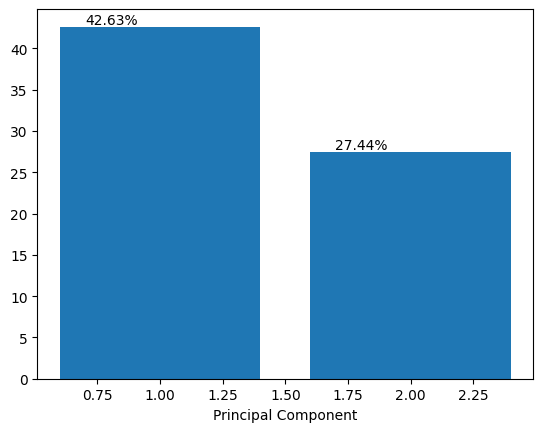

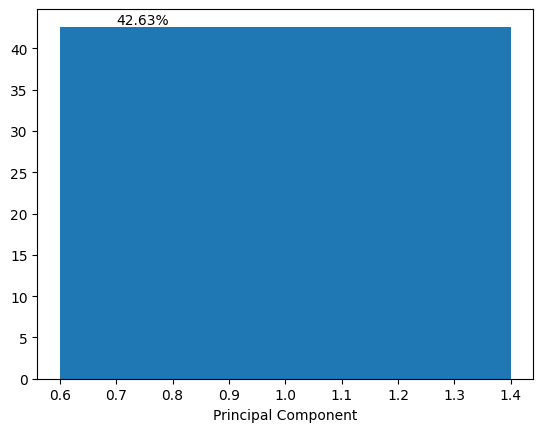

In [276]:
pca_2 = PCA(n_components=(len(features.columns)-4)) # - protected features
pca_1 = PCA(n_components=1)
scaler = StandardScaler()

# normalize column for number of priors, the others are one hot encoded
non_protected_features_scaled = nonprotected.copy()
non_protected_features_scaled = scaler.fit_transform(non_protected_features_scaled)

X_pca_2 = unfair_pca(pca_2, non_protected_features_scaled)
X_pca_1 = unfair_pca(pca_1, non_protected_features_scaled)

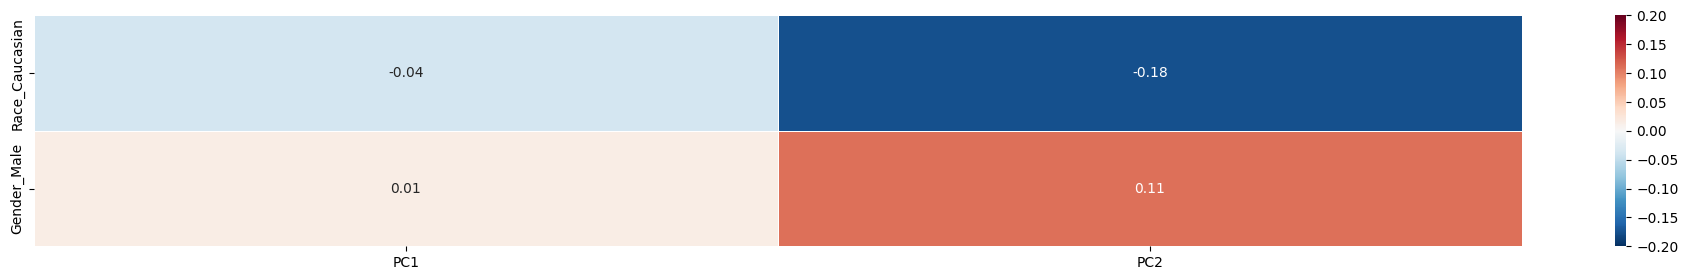

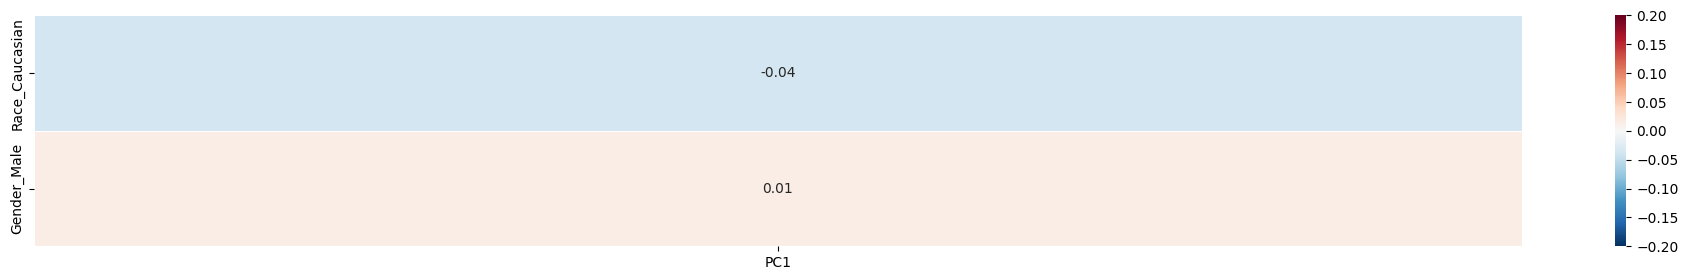

In [277]:
plot_pca_corr(X_pca_2, protected, list(groups.columns))
plot_pca_corr(X_pca_1, protected, list(groups.columns))

In [278]:
# normalize column for number of priores
non_protected_features_scaled_test = nonprotected_test.copy()
non_protected_features_scaled_test = scaler.transform(non_protected_features_scaled_test)

reconstruction_error(X_pca_2, pca_2, non_protected_features_scaled_test, protected_test)
print("------------------")
reconstruction_error(X_pca_1, pca_1, non_protected_features_scaled_test, protected_test)

0.42041427366919676
0.38672757878830516
0.42920827120040445
0.4033289157516108
------------------
0.5977353859247488
0.575213193219553
0.6043618091246085
0.5858269708068363


In [279]:
X_projected_2, Z_2, U_2 = fair_pca(non_protected_features_scaled, protected, 2)
X_projected_1, Z_1, U_1 = fair_pca(non_protected_features_scaled, protected, 1)

In [280]:
features.columns[:-2]

Index(['Number_of_Priors', 'Misdemeanor', 'Age_Group_Age_Below_TwentyFive',
       'Age_Group_Between_TwentyFive_And_FourtyFive'],
      dtype='object')

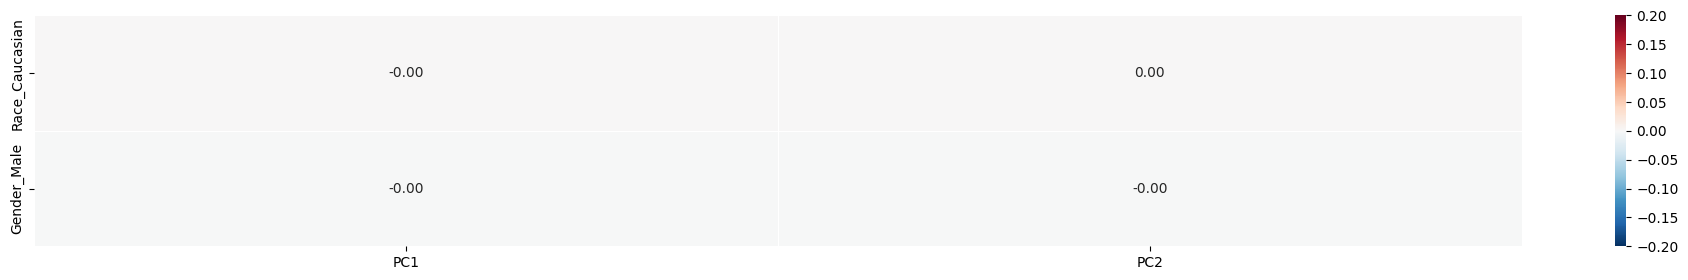

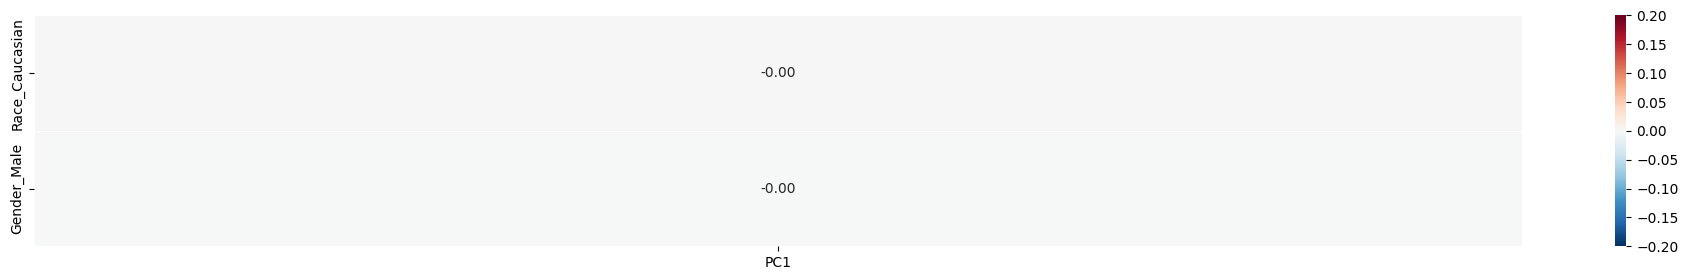

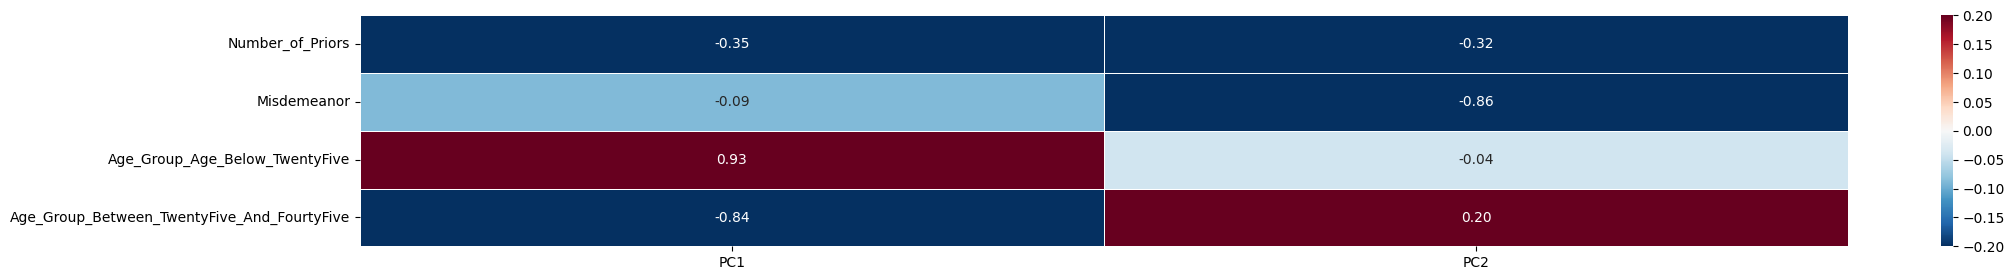

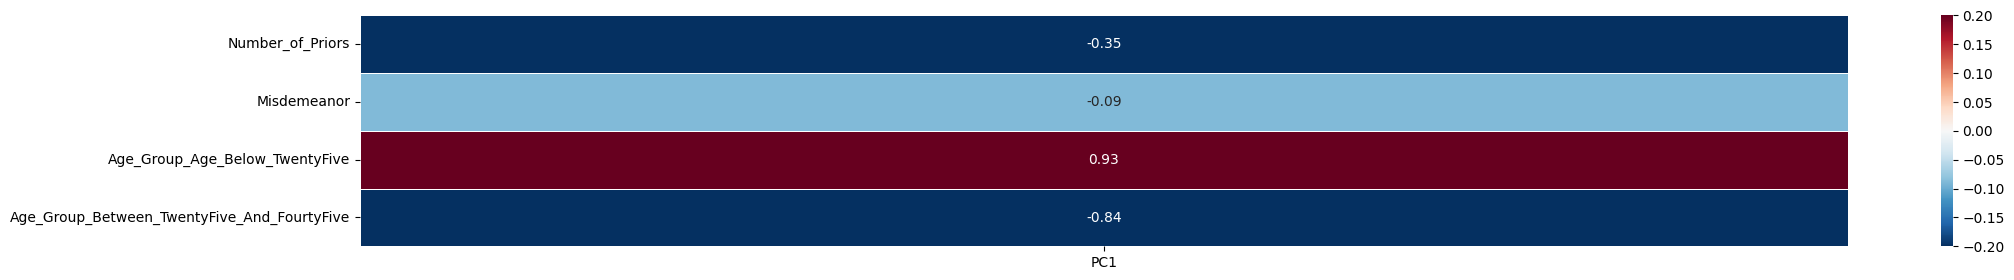

In [281]:
plot_pca_corr(X_projected_2, protected, list(groups.columns))
plot_pca_corr(X_projected_1, protected, list(groups.columns))
plot_pca_corr(X_projected_2, nonprotected, list(features.columns[:-2]))
plot_pca_corr(X_projected_1, nonprotected, list(features.columns[:-2]))

In [282]:
# project test data
X_test_projected_2 = non_protected_features_scaled_test @ U_2
X_test_projected_1 = non_protected_features_scaled_test @ U_1

reconstruction_error_fair_pca(X_projected_2, X_test_projected_2, U_2, non_protected_features_scaled_test, protected_test)
print("------------------")
reconstruction_error_fair_pca(X_projected_1, X_test_projected_1, U_1, non_protected_features_scaled_test, protected_test)

0.4418465371499373
0.40171094070537233
0.43623119095142227
0.43195074837893155
------------------
0.5817429877402873
0.5607276603979475
0.6038596493561891
0.5602744847119115


In [283]:
xgb_2 = xgboost.XGBClassifier(n_estimators=100, max_depth=4, learning_rate=0.1, random_state=0)
scaler_2 = ColumnTransformer([('scaler', MinMaxScaler(), slice(0,None))], remainder='passthrough') # scale only the first column (Number_of_Priors), leave the remainder untouched
xgb_pipeline_2 = Pipeline([('scaler', scaler_2), ('xgb', xgb_2)])
xgb_pipeline_2.fit(X_projected_2, y_train)
y_pred_xgb_2 = xgb_pipeline_2.predict(X_test_projected_2)
metric_scores = calculate_metrics(y_test, y_pred_xgb_2)
print("Balanced accuracy on test set:", metric_scores['accuracy'])
print("Precision on test set:", metric_scores['precision'])
print("Recall on test set:", metric_scores['recall'])
print("F1 score on test set:", metric_scores['f1_score'])

Balanced accuracy on test set: 0.6616803028452802
Precision on test set: 0.6426470588235295
Recall on test set: 0.6052631578947368
F1 score on test set: 0.62339514978602


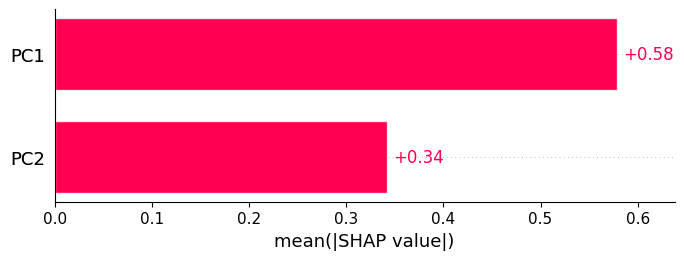

In [284]:
X_train_2 = xgb_pipeline_2['scaler'].transform(X_projected_2)
X_test_2 = xgb_pipeline_2['scaler'].transform(X_test_projected_2)

# explain the model's predictions using SHAP
explainer_2 = shap.Explainer(xgb_pipeline_2['xgb'], X_train_2, feature_names=[f"PC{i}" for i in range(1,len(X_train_2[0])+1)])
shap_values_2 = explainer_2(X_test_2)
shap.plots.bar(shap_values_2, max_display=10)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


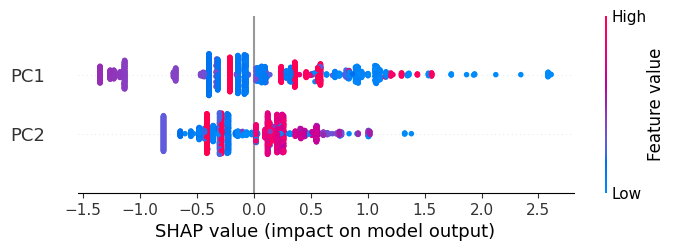

In [285]:
shap.plots.beeswarm(shap_values_2, max_display=10)

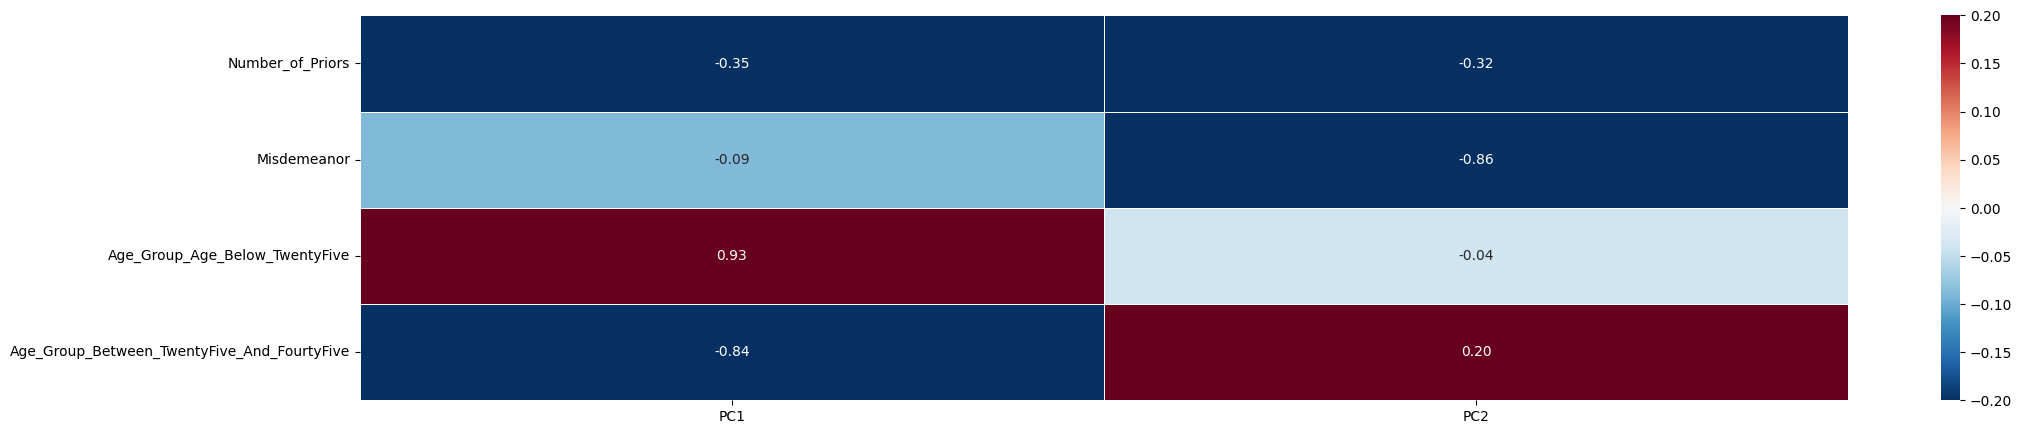

In [286]:
# calculate the correlation between the principal components and the attributes
plot_pca_corr(X_projected_2, nonprotected, list(features.columns[:-2]), (24,5))

In [287]:
#
xgb_1 = xgboost.XGBClassifier(n_estimators=100, max_depth=4, learning_rate=0.1, random_state=0)
scaler_1 = ColumnTransformer([('scaler', MinMaxScaler(), slice(0,None))], remainder='passthrough') # scale only the first column (Number_of_Priors), leave the remainder untouched
xgb_pipeline_1 = Pipeline([('scaler', scaler_1), ('xgb', xgb_1)])
xgb_pipeline_1.fit(X_projected_1, y_train)
y_pred_xgb_1 = xgb_pipeline_1.predict(X_test_projected_1)
metric_scores = calculate_metrics(y_test, y_pred_xgb_1)
print("Balanced accuracy on test set:", metric_scores['accuracy'])
print("Precision on test set:", metric_scores['precision'])
print("Recall on test set:", metric_scores['recall'])
print("F1 score on test set:", metric_scores['f1_score'])

Balanced accuracy on test set: 0.6651252321792391
Precision on test set: 0.6422413793103449
Recall on test set: 0.6191135734072022
F1 score on test set: 0.6304654442877293


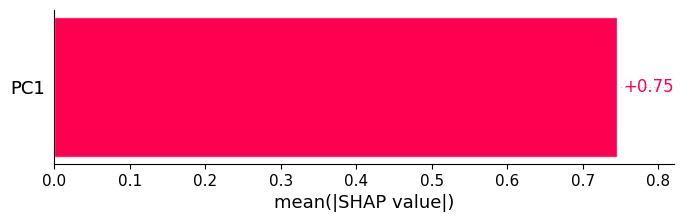

In [288]:
X_train_1 = xgb_pipeline_1['scaler'].transform(X_projected_1)
X_test_1 = xgb_pipeline_1['scaler'].transform(X_test_projected_1)

# explain the model's predictions using SHAP
explainer_1 = shap.Explainer(xgb_pipeline_1['xgb'], X_train_1, feature_names=[f"PC{i}" for i in range(1,len(X_train_1[0])+1)])
shap_values_1 = explainer_1(X_test_1)
shap.plots.bar(shap_values_1, max_display=10)

In [289]:
results_xgb_2 = calc_fair_metrics_flm(y_test, y_pred_xgb_2, group_test)

In [290]:
results_xgb_1 = calc_fair_metrics_flm(y_test, y_pred_xgb_1, group_test)

In [291]:
print(results_xgb_2)
print(results_xgb_1)
print(results)

{'Race_Caucasian': {'equalized_odds': 0.594, 'demographic_parity': 0.55}, 'Gender_Male': {'equalized_odds': 0.591, 'demographic_parity': 0.601}}
{'Race_Caucasian': {'equalized_odds': 0.586, 'demographic_parity': 0.541}, 'Gender_Male': {'equalized_odds': 0.592, 'demographic_parity': 0.615}}
{'Race_Caucasian': {'equalized_odds': 0.591, 'demographic_parity': 0.545}, 'Gender_Male': {'equalized_odds': 0.579, 'demographic_parity': 0.608}}


In [292]:
ratios_xgb_2 = calc_ratios_flm(y_test, y_pred_xgb_2, group_test)
ratios_xgb_1 = calc_ratios_flm(y_test, y_pred_xgb_1, group_test)
print(ratios_xgb_2)
print(ratios_xgb_1)
print(ratio_results)

{'Race_Caucasian': {0: {'tpr': 0.696, 'fpr': 0.345, 'tnr': 0.655, 'fnr': 0.304}, 1: {'tpr': 0.42, 'fpr': 0.205, 'tnr': 0.795, 'fnr': 0.58}}, 'Gender_Male': {0: {'tpr': 0.439, 'fpr': 0.184, 'tnr': 0.816, 'fnr': 0.561}, 1: {'tpr': 0.639, 'fpr': 0.312, 'tnr': 0.688, 'fnr': 0.361}}}
{'Race_Caucasian': {0: {'tpr': 0.717, 'fpr': 0.353, 'tnr': 0.647, 'fnr': 0.283}, 1: {'tpr': 0.42, 'fpr': 0.21, 'tnr': 0.79, 'fnr': 0.58}}, 'Gender_Male': {0: {'tpr': 0.463, 'fpr': 0.189, 'tnr': 0.811, 'fnr': 0.537}, 1: {'tpr': 0.651, 'fpr': 0.319, 'tnr': 0.681, 'fnr': 0.349}}}
{'Race_Caucasian': {0: {'tpr': 0.705, 'fpr': 0.351, 'tnr': 0.649, 'fnr': 0.295}, 1: {'tpr': 0.42, 'fpr': 0.207, 'tnr': 0.793, 'fnr': 0.58}}, 'Gender_Male': {0: {'tpr': 0.455, 'fpr': 0.184, 'tnr': 0.816, 'fnr': 0.545}, 1: {'tpr': 0.643, 'fpr': 0.318, 'tnr': 0.682, 'fnr': 0.357}}}


In [293]:
calc_certainty(y_test, y_pred_xgb_2)

Confidence interval for the f1_score [0.95]:[0.593 - 0.652]


## Wage Equality


In [294]:
# Dataset from https://www.princeton.edu/~mwatson/Stock-Watson_3u/Students/Stock-Watson-EmpiricalExercises-DataSets.htm
# Prottected attribute is 'female'. Target is 'eanwke'

# All values are int or float already
df_weekly_earn = pd.read_csv('data/employment.csv')

# Drop 600 rows of the total 5000 rows, which have nan values
df_weekly_earn = df_weekly_earn.dropna()
df_weekly_earn = df_weekly_earn[df_weekly_earn["race"] != 3] # drop other race
df_weekly_earn['race'] = df_weekly_earn['race'] - 1 # 0 is white, 1 is african american
df_weekly_earn = df_weekly_earn.drop(['self', 'private'], axis=1) # drop self employed, private employed cause opposite of "government" column

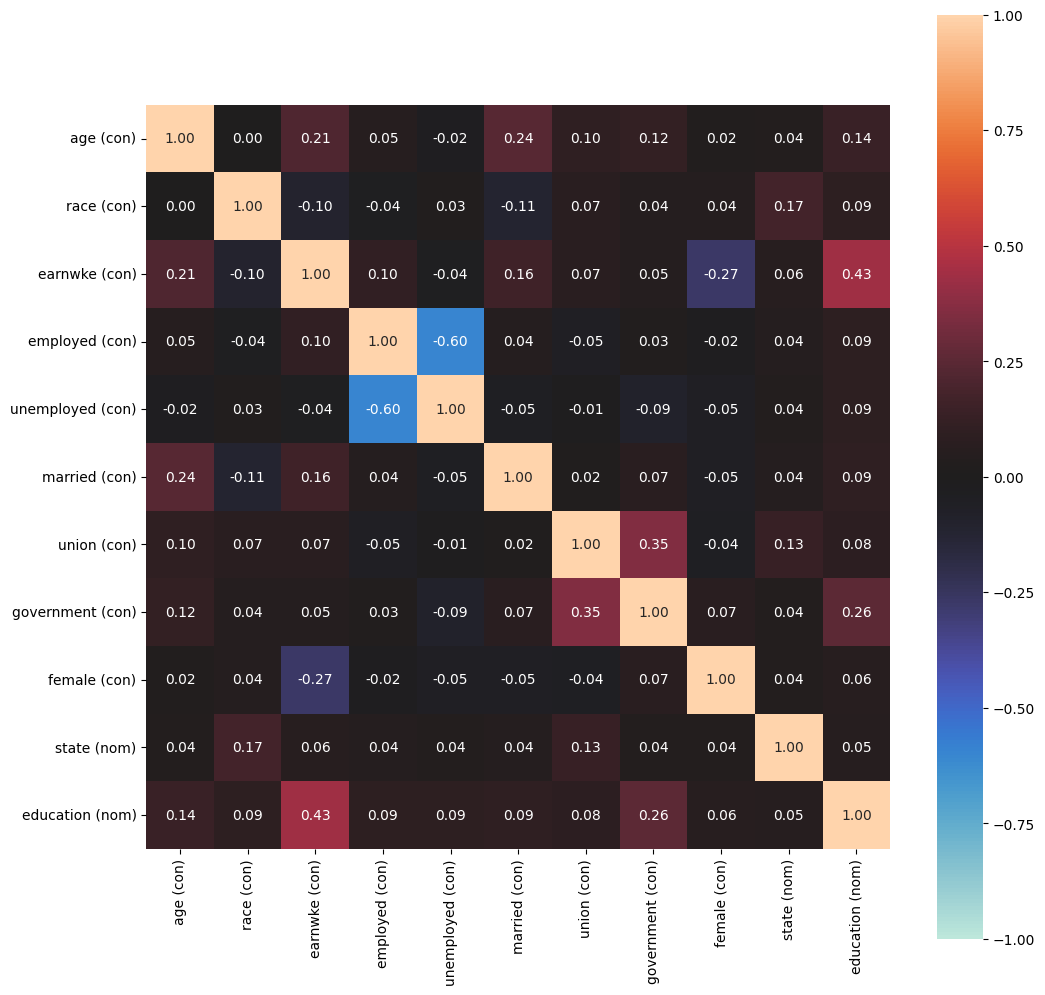

In [295]:
df_weekly_no_dummies = df_weekly_earn.copy()
# create a new 'state' column by using the column names to map to the desired values
df_weekly_no_dummies['state'] = df_weekly_no_dummies.apply(lambda row: 'ne' if row['ne_states'] == 1 else ('so' if row['so_states'] == 1 else ('ce' if row['ce_states'] == 1 else 'we')), axis=1)

# drop the original one-hot encoded columns
df_weekly_no_dummies = df_weekly_no_dummies.drop(['ne_states', 'so_states', 'ce_states', 'we_states'], axis=1)

# create a new 'education' column by using the column names to map to the desired values
df_weekly_no_dummies['education'] = df_weekly_no_dummies.apply(lambda row: "less than high school" if row['educ_lths'] == 1 else ("high school" if row['educ_hs'] == 1 else ("some college" if row['educ_somecol'] == 1 else ("associate's degree" if row['educ_aa'] == 1 else ("bachelor's degree" if row['educ_bac'] == 1 else "advanced degree")))), axis=1)

# drop the original one-hot encoded columns
df_weekly_no_dummies = df_weekly_no_dummies.drop(['educ_lths', 'educ_hs', 'educ_somecol', 'educ_aa', 'educ_bac', 'educ_adv'], axis=1)

# get list of categorical columns
num_cols = df_weekly_no_dummies._get_numeric_data().columns
cat_cols = list(set(df_weekly_no_dummies.columns) - set(num_cols))


dython.nominal.associations(
    df_weekly_no_dummies, nominal_columns=cat_cols, mark_columns=True, figsize=(12, 12));

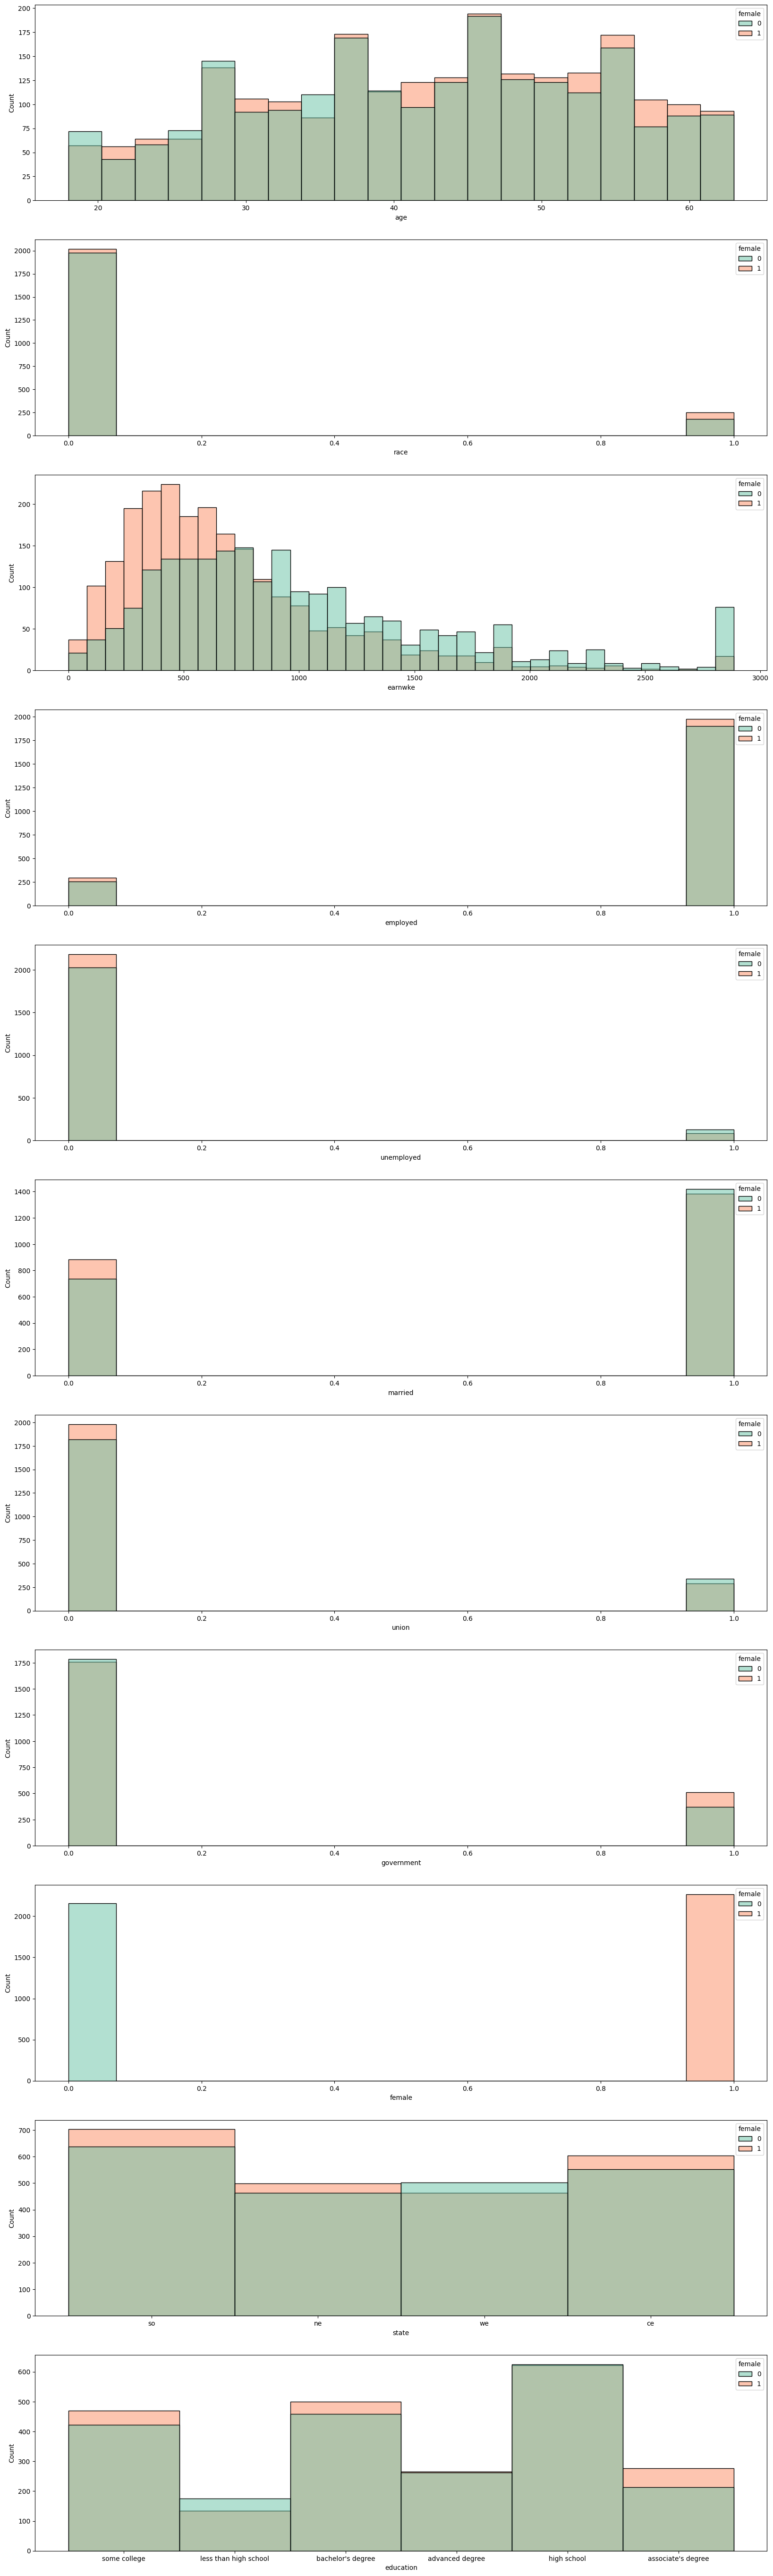

In [296]:
fig, axes = plt.subplots(len(df_weekly_no_dummies.columns), figsize=(20, 70))
for i, feature in enumerate(df_weekly_no_dummies.columns):
    sns.histplot(data=df_weekly_no_dummies, x=feature, hue='female', ax=axes[i], palette='Set2')
plt.show()

In [297]:
median = df_weekly_earn['earnwke'].median()
df_weekly_earn['earnwke'] = (df_weekly_earn['earnwke'] >= median).astype(int)

In [298]:
# remove target variable from features
labels = df_weekly_earn.earnwke
features = df_weekly_earn.drop("earnwke", axis=1)

# reorder so cloumns with "Gender" or "age" in them are at the end
cols = list(features.columns)
protected_cols = []
for i, col in enumerate(cols):
    if ("race" in col) or ("female" in col):
        protected_cols.append(col)

cols = list(set(cols) - set(protected_cols))

cols = cols + protected_cols
features = features[cols]

# identify protected groups
indices = []
for i, f in enumerate(features.columns):
    if ("race" in f) or ("female" in f):
        print("Column ID: %s" % i, "(%s)" % f)
        indices.append(i)

print(indices)

groups = features.iloc[:, indices]

X_train, X_test, y_train, y_test, group_train, group_test = train_test_split(
    features.values, labels.values.reshape(-1), groups, test_size=0.3, random_state=0, shuffle=True)


Column ID: 16 (race)
Column ID: 17 (female)
[16, 17]


In [299]:
# last columns of our data contains the protected features
prot_groups = len(indices)
protected = X_train[:, -prot_groups:]
nonprotected = X_train[:, :-prot_groups]

protected_test = X_test[:, -prot_groups:]
nonprotected_test = X_test[:, :-prot_groups]

In [300]:
xgb = xgboost.XGBClassifier(n_estimators=100, max_depth=4, learning_rate=0.1, random_state=0)
scaler = ColumnTransformer([('scaler', MinMaxScaler(), slice(0, 1))], remainder='passthrough') # scale only the first column (Number_of_Priors), leave the remainder untouched
xgb_pipeline = Pipeline([('scaler', scaler), ('xgb', xgb)])
xgb_pipeline.fit(nonprotected, y_train)
y_pred_xgb = xgb_pipeline.predict(nonprotected_test)
metric_scores = calculate_metrics(y_test, y_pred_xgb)
print("Balanced accuracy on test set:", metric_scores['accuracy'])
print("Precision on test set:", metric_scores['precision'])
print("Recall on test set:", metric_scores['recall'])
print("F1 score on test set:", metric_scores['f1_score'])

Balanced accuracy on test set: 0.6692733146398788
Precision on test set: 0.6661514683153014
Recall on test set: 0.6590214067278287
F1 score on test set: 0.6625672559569561


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


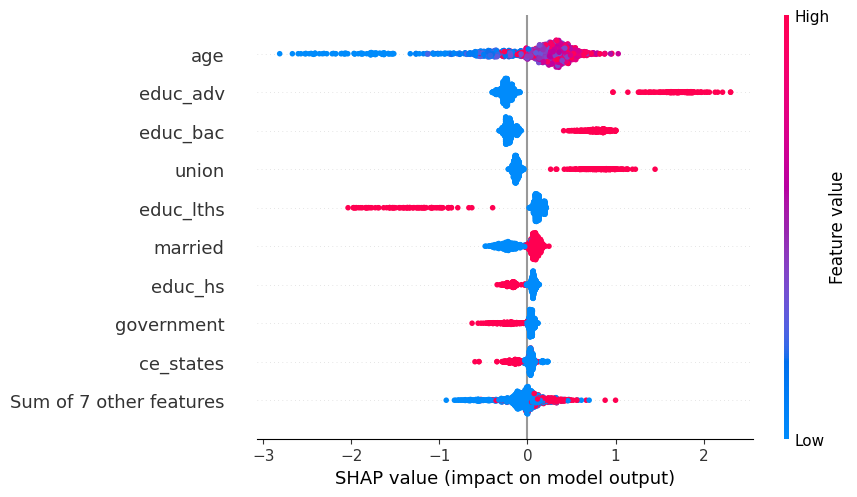

In [301]:
X_train_ = xgb_pipeline['scaler'].transform(nonprotected)
X_test_ = xgb_pipeline['scaler'].transform(nonprotected_test)

# explain the model's predictions using SHAP
explainer = shap.Explainer(xgb_pipeline['xgb'], X_train_, feature_names=features.columns[:-2])
shap_values = explainer(X_test_)
shap.plots.beeswarm(shap_values, max_display=10)

In [302]:
results = calc_fair_metrics_flm(y_test, y_pred_xgb, group_test)
ratios = calc_ratios_flm(y_test, y_pred_xgb, group_test)
print(results)
print(ratios)

{'race': {'equalized_odds': 0.811, 'demographic_parity': 0.751}, 'female': {'equalized_odds': 0.726, 'demographic_parity': 0.924}}
{'race': {0: {'tpr': 0.666, 'fpr': 0.324, 'tnr': 0.676, 'fnr': 0.334}, 1: {'tpr': 0.541, 'fpr': 0.295, 'tnr': 0.705, 'fnr': 0.459}}, 'female': {0: {'tpr': 0.655, 'fpr': 0.258, 'tnr': 0.742, 'fnr': 0.345}, 1: {'tpr': 0.665, 'fpr': 0.356, 'tnr': 0.644, 'fnr': 0.335}}}


In [303]:
calc_certainty(y_test, y_pred_xgb)

Confidence interval for the f1_score [0.95]:[0.634 - 0.694]


### Fair PCA


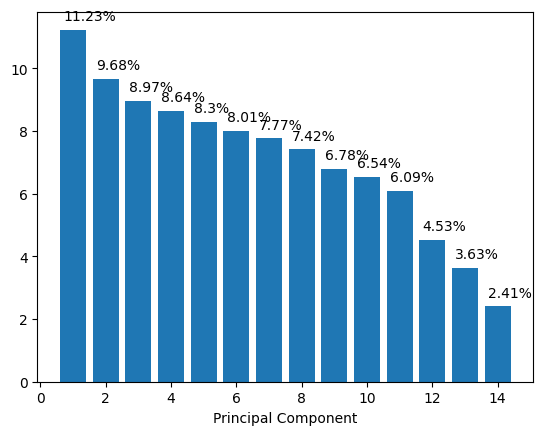

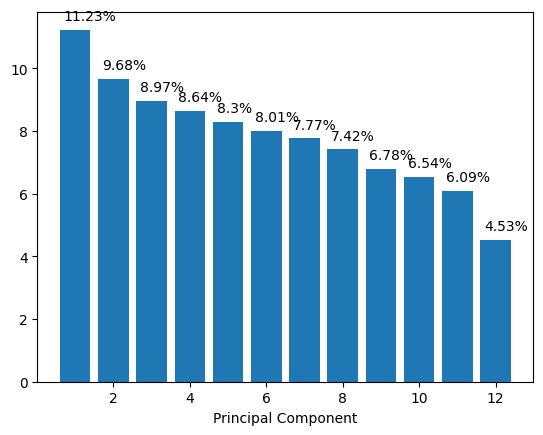

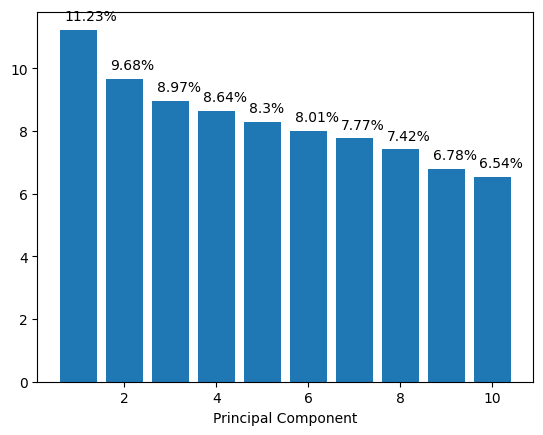

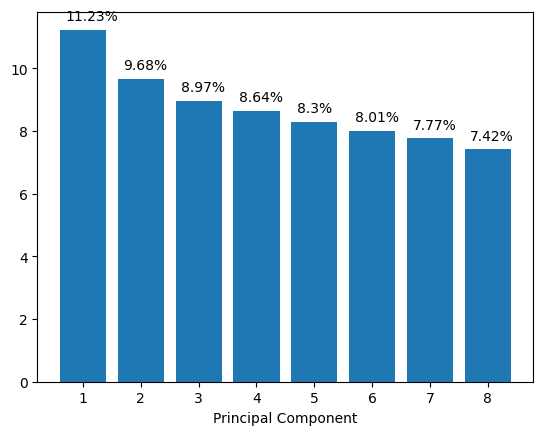

In [304]:
pca_14 = PCA(n_components=(len(features.columns)-4)) # - protected features
pca_12 = PCA(n_components=(len(features.columns)-6)) # trying different amounts of PCs
pca_10 = PCA(n_components=(len(features.columns)-8)) # trying different amounts of PCs
pca_8 = PCA(n_components=(len(features.columns)-10)) # trying different amounts of PCs
scaler = StandardScaler()
# normalize column for number of priors, the others are one hot encoded
non_protected_features_scaled = nonprotected.copy()
non_protected_features_scaled = scaler.fit_transform(non_protected_features_scaled)

X_pca_14 = unfair_pca(pca_14, non_protected_features_scaled)
X_pca_12 = unfair_pca(pca_12, non_protected_features_scaled)
X_pca_10 = unfair_pca(pca_10, non_protected_features_scaled)
X_pca_8 = unfair_pca(pca_8, non_protected_features_scaled)

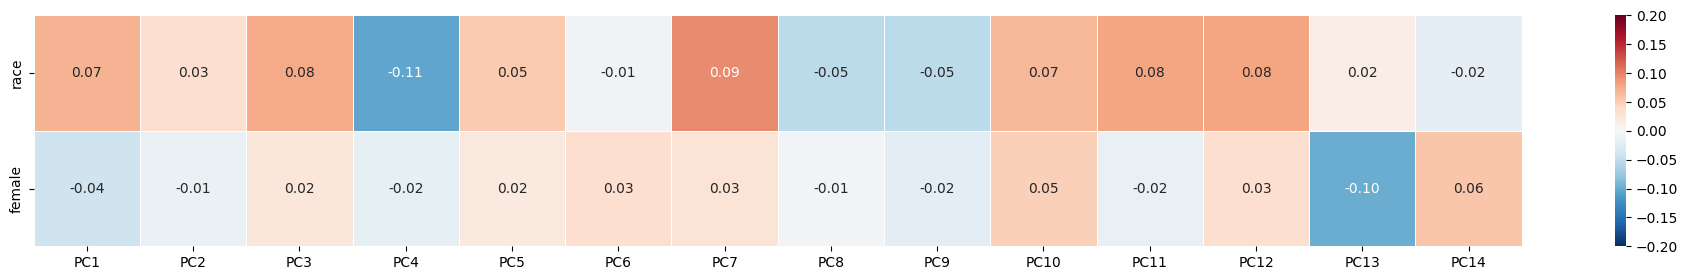

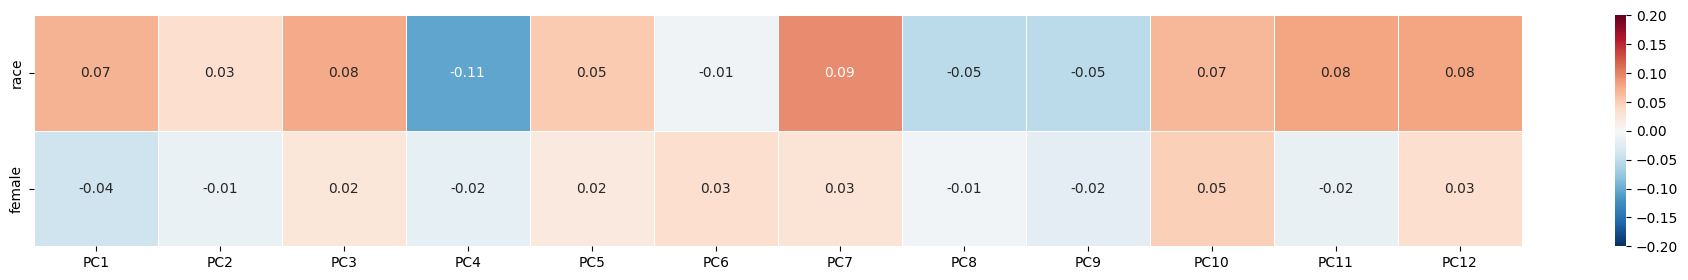

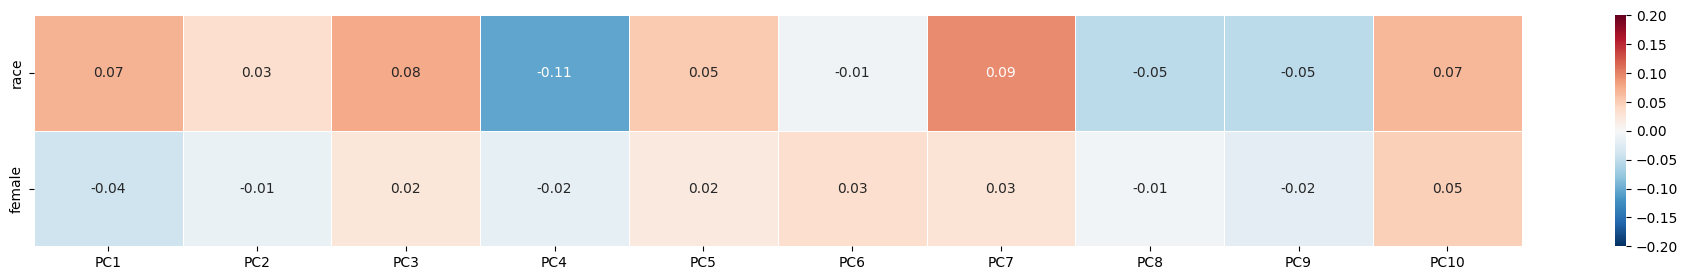

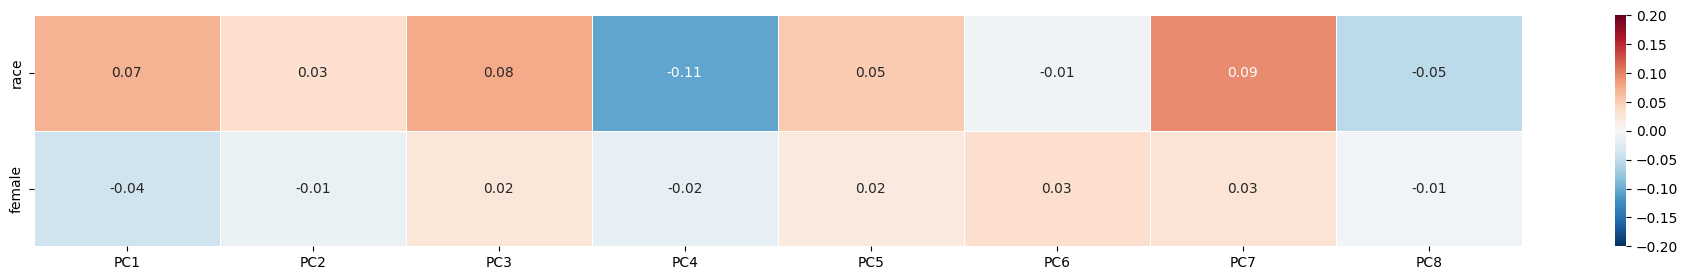

In [305]:
plot_pca_corr(X_pca_14, protected, list(groups))
plot_pca_corr(X_pca_12, protected, list(groups))
plot_pca_corr(X_pca_10, protected, list(groups))
plot_pca_corr(X_pca_8, protected, list(groups))

In [306]:
# normalize column for number of priores
non_protected_features_scaled_test = nonprotected_test.copy()
non_protected_features_scaled_test = scaler.transform(non_protected_features_scaled_test)

reconstruction_error(X_pca_14, pca_14, non_protected_features_scaled_test, protected_test)
print("--------------------------")
reconstruction_error(X_pca_12, pca_12, non_protected_features_scaled_test, protected_test)
print("--------------------------")
reconstruction_error(X_pca_10, pca_10, non_protected_features_scaled_test, protected_test)
print("--------------------------")
reconstruction_error(X_pca_8, pca_8, non_protected_features_scaled_test, protected_test)

1.6730270718184276e-15
1.6661992421313496e-15
1.5316910632346824e-15
1.6827509532705866e-15
--------------------------
0.10153158469634023
0.10158306513922194
0.12153751950526816
0.09966261043927102
--------------------------
0.2281227001972155
0.23188458818848265
0.26430192364474114
0.2267178380058157
--------------------------
0.3513550473555122
0.36653876463806867
0.39668414229804305
0.355231487147036


In [307]:
X_projected_14, Z_14, U_14 = fair_pca(non_protected_features_scaled, protected, 14)
X_projected_12, Z_12, U_12 = fair_pca(non_protected_features_scaled, protected, 12)
X_projected_10, Z_10, U_10 = fair_pca(non_protected_features_scaled, protected, 10)
X_projected_8, Z_8, U_8 = fair_pca(non_protected_features_scaled, protected, 8)

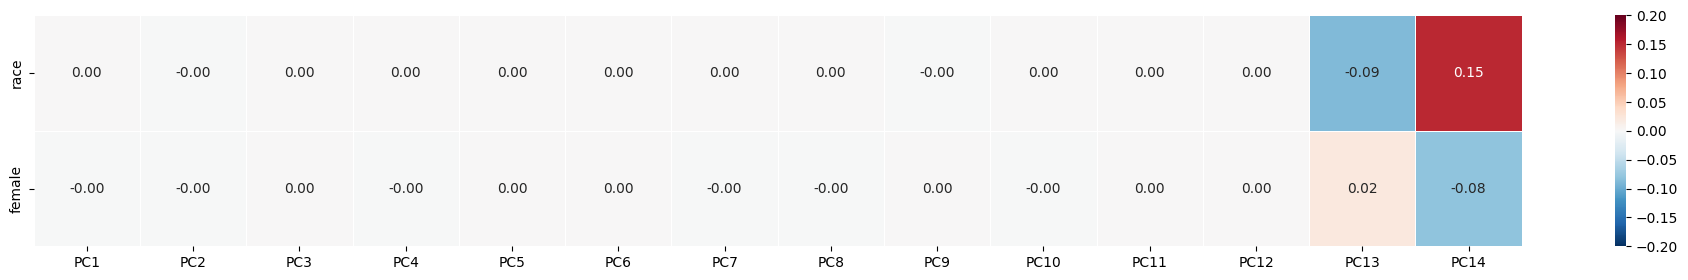

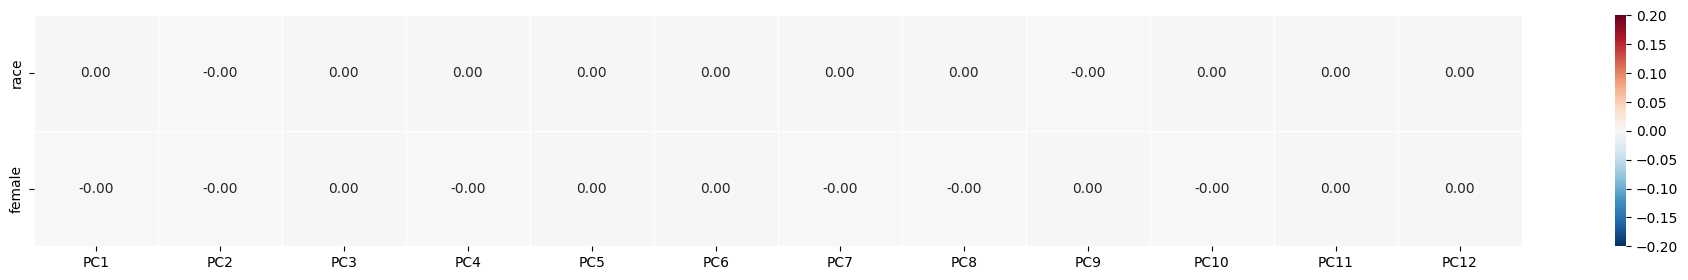

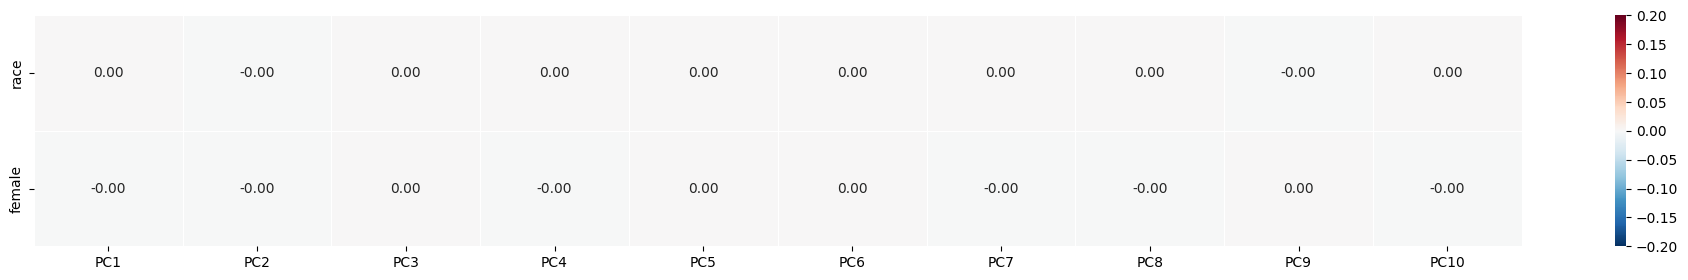

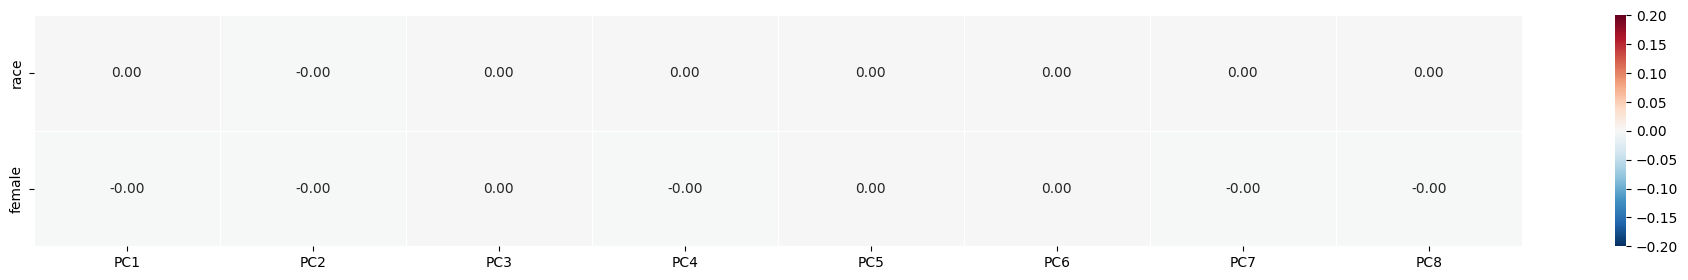

In [308]:
plot_pca_corr(X_projected_14, protected, list(groups))
plot_pca_corr(X_projected_12, protected, list(groups))
plot_pca_corr(X_projected_10, protected, list(groups))
plot_pca_corr(X_projected_8, protected, list(groups))

In [309]:
# project test data
X_test_projected_14 = non_protected_features_scaled_test @ U_14
X_test_projected_12 = non_protected_features_scaled_test @ U_12
X_test_projected_10 = non_protected_features_scaled_test @ U_10
X_test_projected_8 = non_protected_features_scaled_test @ U_8

reconstruction_error_fair_pca(X_projected_14, X_test_projected_14, U_14, non_protected_features_scaled_test, protected_test)
print("----------------------------------")
reconstruction_error_fair_pca(X_projected_12, X_test_projected_12, U_12, non_protected_features_scaled_test, protected_test)
print("----------------------------------")
reconstruction_error_fair_pca(X_projected_10, X_test_projected_10, U_10, non_protected_features_scaled_test, protected_test)
print("----------------------------------")
reconstruction_error_fair_pca(X_projected_8, X_test_projected_8, U_8, non_protected_features_scaled_test, protected_test)

0.26118993892548376
0.28625621459501743
0.2965342812145702
0.27133312000459386
----------------------------------
0.26118993892548376
0.28625621459501743
0.29653428121457026
0.27133312000459386
----------------------------------
0.3369133549023763
0.3497688889512558
0.35921214725104256
0.34171986983545266
----------------------------------
0.429004040006658
0.44478794194164817
0.45441689897987453
0.4350917639816199


Balanced accuracy on test set: 0.674352761821795
Precision on test set: 0.6761904761904762
Recall on test set: 0.6513761467889908
F1 score on test set: 0.6635514018691588


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


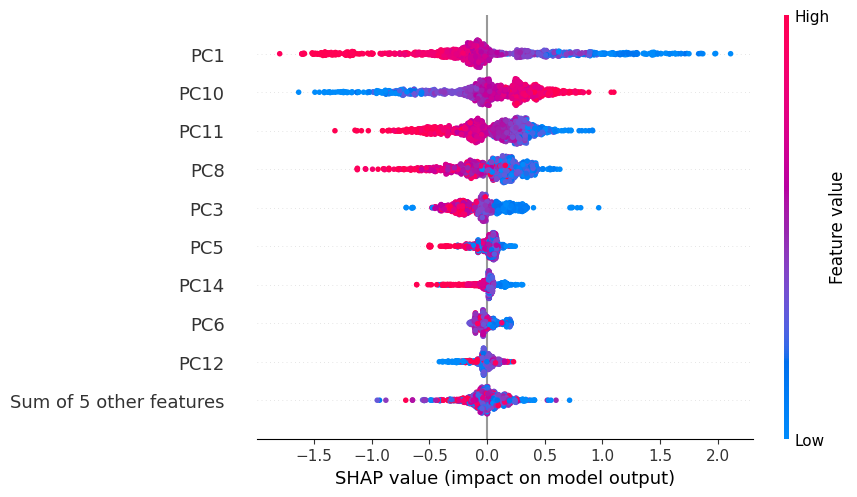

In [310]:
xgb_14 = xgboost.XGBClassifier(n_estimators=100, max_depth=4, learning_rate=0.1, random_state=0)
scaler_14 = ColumnTransformer([('scaler', MinMaxScaler(), slice(0, 1))], remainder='passthrough') # scale only the first column (Number_of_Priors), leave the remainder untouched
xgb_pipeline_14 = Pipeline([('scaler', scaler_14), ('xgb', xgb_14)])
xgb_pipeline_14.fit(X_projected_14, y_train)
y_pred_xgb_14 = xgb_pipeline_14.predict(X_test_projected_14)
metric_scores = calculate_metrics(y_test, y_pred_xgb_14)
print("Balanced accuracy on test set:", metric_scores['accuracy'])
print("Precision on test set:", metric_scores['precision'])
print("Recall on test set:", metric_scores['recall'])
print("F1 score on test set:", metric_scores['f1_score'])

X_train_14 = xgb_pipeline_14['scaler'].transform(X_projected_14)
X_test_14 = xgb_pipeline_14['scaler'].transform(X_test_projected_14)

# explain the model's predictions using SHAP
explainer_14 = shap.Explainer(xgb_pipeline_14['xgb'], X_train_14, feature_names=[f"PC{i}" for i in range(1, len(X_train_14[0])+1)])
shap_values_14 = explainer_14(X_test_14)
shap.plots.beeswarm(shap_values_14, max_display=10)

Balanced accuracy on test set: 0.6699924681712175
Precision on test set: 0.6677018633540373
Recall on test set: 0.6574923547400612
F1 score on test set: 0.6625577812018489


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


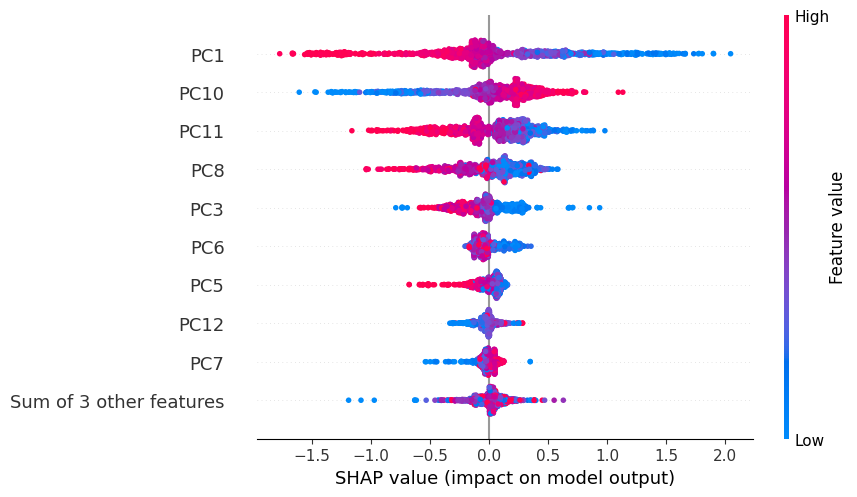

In [311]:
xgb_12 = xgboost.XGBClassifier(n_estimators=100, max_depth=4, learning_rate=0.1, random_state=0)
scaler_12 = ColumnTransformer([('scaler', MinMaxScaler(), slice(0, 1))], remainder='passthrough') # scale only the first column (Number_of_Priors), leave the remainder untouched
xgb_pipeline_12 = Pipeline([('scaler', scaler_12), ('xgb', xgb_12)])
xgb_pipeline_12.fit(X_projected_12, y_train)
y_pred_xgb_12 = xgb_pipeline_12.predict(X_test_projected_12)
metric_scores = calculate_metrics(y_test, y_pred_xgb_12)
print("Balanced accuracy on test set:", metric_scores['accuracy'])
print("Precision on test set:", metric_scores['precision'])
print("Recall on test set:", metric_scores['recall'])
print("F1 score on test set:", metric_scores['f1_score'])

X_train_12 = xgb_pipeline_12['scaler'].transform(X_projected_12)
X_test_12 = xgb_pipeline_12['scaler'].transform(X_test_projected_12)

# explain the model's predictions using SHAP
explainer_12 = shap.Explainer(xgb_pipeline_12['xgb'], X_train_12, feature_names=[f"PC{i}" for i in range(1, len(X_train_12[0])+1)])
shap_values_12 = explainer_12(X_test_12)
shap.plots.beeswarm(shap_values_12, max_display=10)

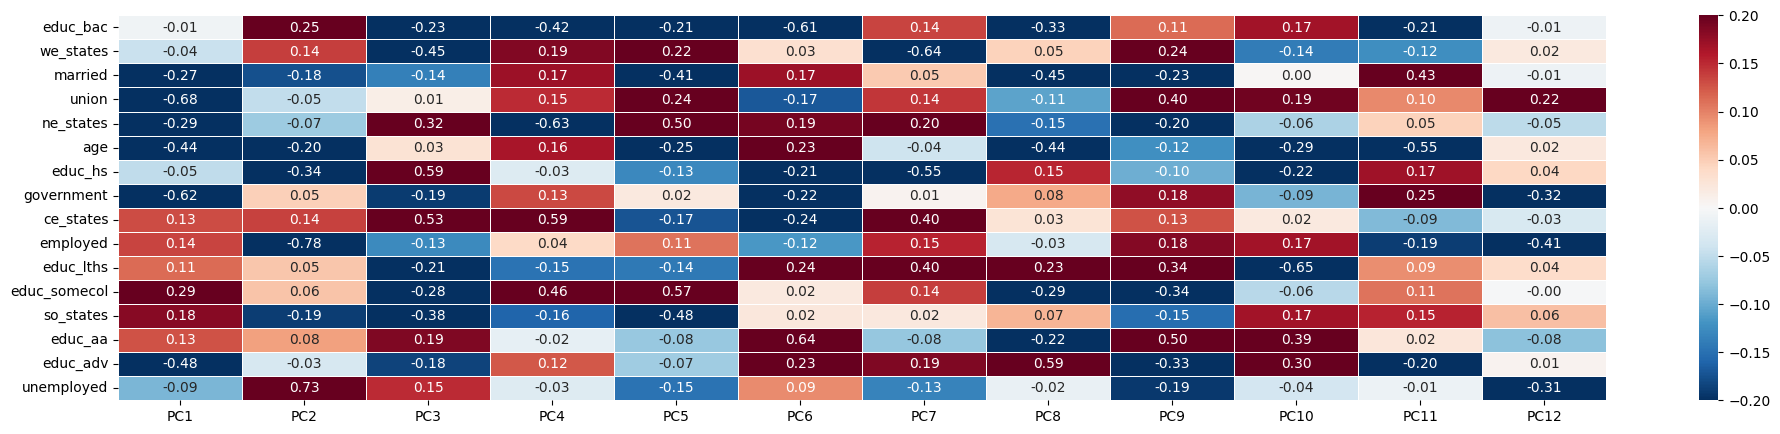

In [312]:
# calculate the correlation between the principal components and the attributes
plot_pca_corr(X_projected_12, nonprotected, list(features.columns[:-2]), (24,5))

Balanced accuracy on test set: 0.6683726712583599
Precision on test set: 0.668769716088328
Recall on test set: 0.6483180428134556
F1 score on test set: 0.6583850931677019


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


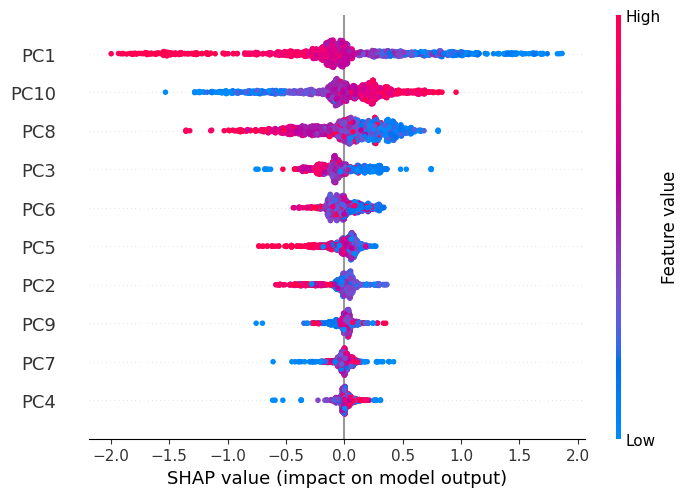

In [313]:
xgb_10 = xgboost.XGBClassifier(n_estimators=100, max_depth=4, learning_rate=0.1, random_state=0)
scaler_10 = ColumnTransformer([('scaler', MinMaxScaler(), slice(0, 1))], remainder='passthrough') # scale only the first column (Number_of_Priors), leave the remainder untouched
xgb_pipeline_10 = Pipeline([('scaler', scaler_10), ('xgb', xgb_10)])
xgb_pipeline_10.fit(X_projected_10, y_train)
y_pred_xgb_10 = xgb_pipeline_10.predict(X_test_projected_10)
metric_scores = calculate_metrics(y_test, y_pred_xgb_10)
print("Balanced accuracy on test set:", metric_scores['accuracy'])
print("Precision on test set:", metric_scores['precision'])
print("Recall on test set:", metric_scores['recall'])
print("F1 score on test set:", metric_scores['f1_score'])

X_train_10 = xgb_pipeline_10['scaler'].transform(X_projected_10)
X_test_10 = xgb_pipeline_10['scaler'].transform(X_test_projected_10)

# explain the model's predictions using SHAP
explainer_10 = shap.Explainer(xgb_pipeline_10['xgb'], X_train_10, feature_names=[f"PC{i}" for i in range(1, len(X_train_10[0])+1)])
shap_values_10 = explainer_10(X_test_10)
shap.plots.beeswarm(shap_values_10, max_display=10)

Balanced accuracy on test set: 0.6631797929200809
Precision on test set: 0.6614664586583463
Recall on test set: 0.6483180428134556
F1 score on test set: 0.6548262548262548


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


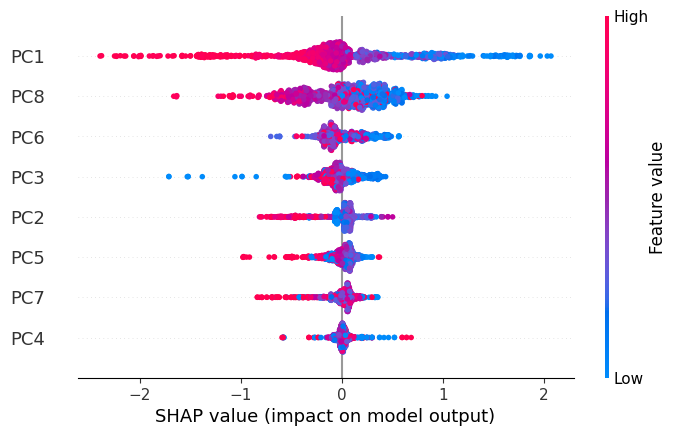

In [314]:
xgb_8 = xgboost.XGBClassifier(n_estimators=100, max_depth=4, learning_rate=0.1, random_state=0)
scaler_8 = ColumnTransformer([('scaler', MinMaxScaler(), slice(0, 1))], remainder='passthrough') # scale only the first column (Number_of_Priors), leave the remainder untouched
xgb_pipeline_8 = Pipeline([('scaler', scaler_8), ('xgb', xgb_8)])
xgb_pipeline_8.fit(X_projected_8, y_train)
y_pred_xgb_8 = xgb_pipeline_8.predict(X_test_projected_8)
metric_scores = calculate_metrics(y_test, y_pred_xgb_8)
print("Balanced accuracy on test set:", metric_scores['accuracy'])
print("Precision on test set:", metric_scores['precision'])
print("Recall on test set:", metric_scores['recall'])
print("F1 score on test set:", metric_scores['f1_score'])

X_train_8 = xgb_pipeline_8['scaler'].transform(X_projected_8)
X_test_8 = xgb_pipeline_8['scaler'].transform(X_test_projected_8)

# explain the model's predictions using SHAP
explainer_8 = shap.Explainer(xgb_pipeline_8['xgb'], X_train_8, feature_names=[f"PC{i}" for i in range(1, len(X_train_8[0])+1)])
shap_values_8 = explainer_8(X_test_8)
shap.plots.beeswarm(shap_values_8, max_display=10)

In [315]:
calc_certainty(y_test, y_pred_xgb_12)

Confidence interval for the f1_score [0.95]:[0.633 - 0.692]


In [316]:
results_xgb_14 = calc_fair_metrics_flm(y_test, y_pred_xgb_14, group_test)
results_xgb_12 = calc_fair_metrics_flm(y_test, y_pred_xgb_12, group_test)
results_xgb_10 = calc_fair_metrics_flm(y_test, y_pred_xgb_10, group_test)
results_xgb_8 = calc_fair_metrics_flm(y_test, y_pred_xgb_8, group_test)
print(results_xgb_14)
print(results_xgb_12)
print(results_xgb_10)
print(results_xgb_8)

{'race': {'equalized_odds': 0.831, 'demographic_parity': 0.753}, 'female': {'equalized_odds': 0.7, 'demographic_parity': 0.908}}
{'race': {'equalized_odds': 0.92, 'demographic_parity': 0.811}, 'female': {'equalized_odds': 0.687, 'demographic_parity': 0.915}}
{'race': {'equalized_odds': 0.76, 'demographic_parity': 0.748}, 'female': {'equalized_odds': 0.689, 'demographic_parity': 0.926}}
{'race': {'equalized_odds': 0.906, 'demographic_parity': 0.815}, 'female': {'equalized_odds': 0.705, 'demographic_parity': 0.906}}


In [317]:
print(results)

{'race': {'equalized_odds': 0.811, 'demographic_parity': 0.751}, 'female': {'equalized_odds': 0.726, 'demographic_parity': 0.924}}


In [318]:
ratios_xgb_14 = calc_ratios_flm(y_test, y_pred_xgb_14, group_test)
ratios_xgb_12 = calc_ratios_flm(y_test, y_pred_xgb_12, group_test)
ratios_xgb_10 = calc_ratios_flm(y_test, y_pred_xgb_10, group_test)
ratios_xgb_8 = calc_ratios_flm(y_test, y_pred_xgb_8, group_test)
print(ratios_xgb_14)
print(ratios_xgb_12)
print(ratios_xgb_10)
print(ratios_xgb_8)


{'race': {0: {'tpr': 0.655, 'fpr': 0.309, 'tnr': 0.691, 'fnr': 0.345}, 1: {'tpr': 0.595, 'fpr': 0.256, 'tnr': 0.744, 'fnr': 0.405}}, 'female': {0: {'tpr': 0.653, 'fpr': 0.238, 'tnr': 0.762, 'fnr': 0.347}, 1: {'tpr': 0.649, 'fpr': 0.34, 'tnr': 0.66, 'fnr': 0.351}}}
{'race': {0: {'tpr': 0.66, 'fpr': 0.32, 'tnr': 0.68, 'fnr': 0.34}, 1: {'tpr': 0.622, 'fpr': 0.295, 'tnr': 0.705, 'fnr': 0.378}}, 'female': {0: {'tpr': 0.663, 'fpr': 0.246, 'tnr': 0.754, 'fnr': 0.337}, 1: {'tpr': 0.649, 'fpr': 0.358, 'tnr': 0.642, 'fnr': 0.351}}}
{'race': {0: {'tpr': 0.65, 'fpr': 0.32, 'tnr': 0.68, 'fnr': 0.35}, 1: {'tpr': 0.622, 'fpr': 0.244, 'tnr': 0.756, 'fnr': 0.378}}, 'female': {0: {'tpr': 0.648, 'fpr': 0.242, 'tnr': 0.758, 'fnr': 0.352}, 1: {'tpr': 0.649, 'fpr': 0.351, 'tnr': 0.649, 'fnr': 0.351}}}
{'race': {0: {'tpr': 0.65, 'fpr': 0.326, 'tnr': 0.674, 'fnr': 0.35}, 1: {'tpr': 0.622, 'fpr': 0.295, 'tnr': 0.705, 'fnr': 0.378}}, 'female': {0: {'tpr': 0.658, 'fpr': 0.254, 'tnr': 0.746, 'fnr': 0.342}, 1: {'t

In [319]:
print(ratios)

{'race': {0: {'tpr': 0.666, 'fpr': 0.324, 'tnr': 0.676, 'fnr': 0.334}, 1: {'tpr': 0.541, 'fpr': 0.295, 'tnr': 0.705, 'fnr': 0.459}}, 'female': {0: {'tpr': 0.655, 'fpr': 0.258, 'tnr': 0.742, 'fnr': 0.345}, 1: {'tpr': 0.665, 'fpr': 0.356, 'tnr': 0.644, 'fnr': 0.335}}}
